In [7]:
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")  
client = MongoClient(os.getenv("MONGODB_CONNECTION_STRING"))
db = client["cricket_elo"]
player_ratings_collection = db["player_ratings"]

def get_top_n_players(n=10):
    """Fetches the top N players based on their latest Elo rating."""
    players = list(player_ratings_collection.find({}, {"_id": 0, "player_name": 1, "batting_rating": 1, "bowling_rating": 1}))

    latest_batting_ratings = []
    latest_bowling_ratings = []
    
    for player in players:
        player_name = player["player_name"]
        
        # Process Batting Rating
        if player.get("batting_rating"):
            batting_df = pd.DataFrame(player["batting_rating"])
            if not batting_df.empty:
                latest_entry = batting_df.loc[batting_df["date"].idxmax()]  # Get latest match rating
                latest_batting_ratings.append({
                    "player_name": player_name,
                    "batting_rating": latest_entry["rating"],
                    "n_entries": len(batting_df)
                })

        # Process Bowling Rating
        if player.get("bowling_rating"):
            bowling_df = pd.DataFrame(player["bowling_rating"])
            if not bowling_df.empty:
                latest_entry = bowling_df.loc[bowling_df["date"].idxmax()]  # Get latest match rating
                latest_bowling_ratings.append({
                    "player_name": player_name,
                    "bowling_rating": latest_entry["rating"],
                    "n_entries": len(bowling_df)
                })

    # Convert lists to DataFrames
    df_batting = pd.DataFrame(latest_batting_ratings)
    df_bowling = pd.DataFrame(latest_bowling_ratings)

    # Filter out default ratings (1000) and players with fewer than 20 matches
    top_batters = (
        df_batting
        .loc[(df_batting["batting_rating"] != 1000) & (df_batting["n_entries"] > 1)]
        .nlargest(n, "batting_rating")[["player_name", "batting_rating"]]
        .reset_index(drop=True)
    )

    top_bowlers = (
        df_bowling
        .loc[(df_bowling["bowling_rating"] != 1000) & (df_bowling["n_entries"] > 1)]
        .nlargest(n, "bowling_rating")[["player_name", "bowling_rating"]]
        .reset_index(drop=True)
    )

    # Merge both DataFrames for an overall ranking
    df_combined = pd.merge(df_batting, df_bowling, on="player_name", how="outer")

    df_combined["allrounder_rating"] = 2 * (df_combined["batting_rating"] * df_combined["bowling_rating"]) / (df_combined["batting_rating"] + df_combined["bowling_rating"])
    
    top_allrounders = (
        df_combined
        .loc[(df_combined["allrounder_rating"] != 1000)]
        .nlargest(n, "allrounder_rating")[["player_name", "allrounder_rating"]]
        .reset_index(drop=True)
    )

    # Adjust index to start from 1
    top_batters.index += 1
    top_bowlers.index += 1
    top_allrounders.index += 1

    return top_batters, top_bowlers, top_allrounders, df_combined

# Fetch and display top players
n = 10
top_batters, top_bowlers, top_allrounders, df = get_top_n_players(n)
print(f"Top {n} Batters:\n", top_batters)
print(f"\nTop {n} Bowlers:\n", top_bowlers)
print(f"\nTop {n} All-rounders:\n", top_allrounders)

Top 10 Batters:
         player_name  batting_rating
1          MS Dhoni     1357.232595
2          N Pooran     1354.204872
3          SA Yadav     1354.094594
4          T Stubbs     1353.412926
5        RM Patidar     1352.951277
6           PD Salt     1350.604256
7   J Fraser-McGurk     1350.508455
8         SP Narine     1347.970249
9   Abhishek Sharma     1345.341674
10  B Sai Sudharsan     1345.303576

Top 10 Bowlers:
      player_name  bowling_rating
1      SP Narine     1377.336635
2       CV Varun     1376.261771
3     MJ Santner     1365.877864
4   M Theekshana     1362.866006
5      PP Chawla     1360.427472
6      JJ Bumrah     1358.043147
7       R Ashwin     1355.968486
8       AR Patel     1355.744426
9       TA Boult     1354.609522
10   M Pathirana     1354.437638

Top 10 All-rounders:
         player_name  allrounder_rating
1         SP Narine        1362.495224
2           C Green        1345.576826
3         RA Jadeja        1340.145655
4   Abhishek Sharma        

In [122]:
df.sort_values(by='batting_rating', ascending=False).loc[df['player_name'] == 'V Kohli']

,player_name,batting_rating,n_entries_x,bowling_rating,n_entries_y,allrounder_rating
439,V Kohli,1350.663357,132,1258.719771,132,1303.071713


<Axes: ylabel='Frequency'>

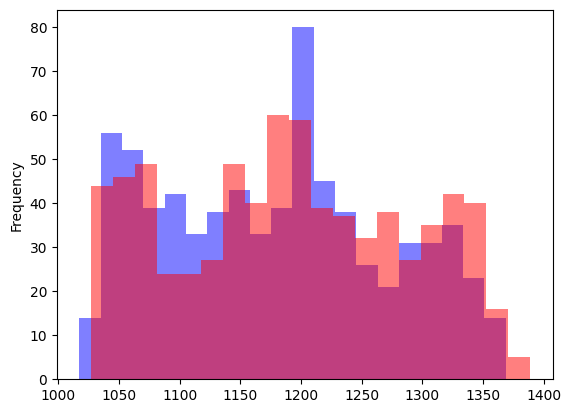

In [3]:
df['batting_rating'].plot.hist(bins=20, alpha=0.5, color='blue', label='Batting Ratings')
df['bowling_rating'].plot.hist(bins=20, alpha=0.5, color='red', label='Bowling Ratings')

<Axes: title={'center': 'Virat Kohli Batting Ratings'}, xlabel='Date', ylabel='Rating'>

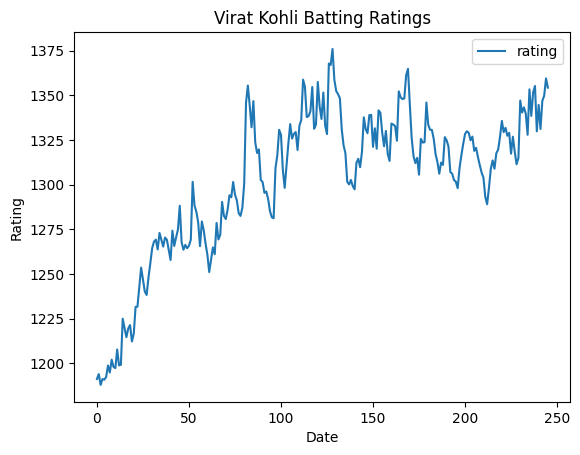

In [4]:
virat_kohli = player_ratings_collection.find_one({"player_name": "V Kohli"}, {"_id": 0, "player_name": 1, "batting_rating": 1})
df_kohli = pd.DataFrame(virat_kohli["batting_rating"])
df_kohli["date"] = pd.to_datetime(df_kohli["date"])
df_kohli.plot(y='rating', title='Virat Kohli Batting Ratings', xlabel='Date', ylabel='Rating')

<Axes: >

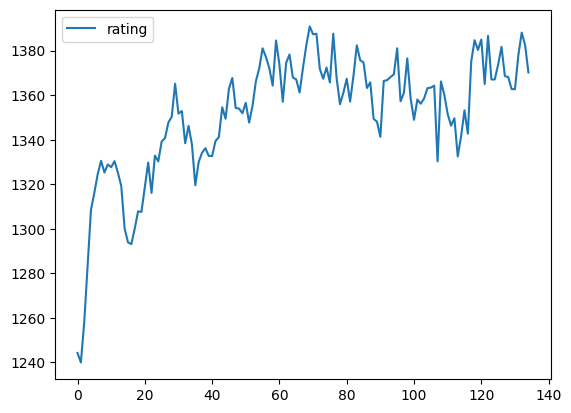

In [5]:
bumrah = player_ratings_collection.find_one({"player_name": "JJ Bumrah"}, {"_id": 0, "player_name": 1, "bowling_rating": 1})
df_bumrah = pd.DataFrame(bumrah["bowling_rating"])
df_bumrah["date"] = pd.to_datetime(df_bumrah["date"])
df_bumrah.plot(y='rating')

In [6]:
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")  
client = MongoClient(os.getenv("MONGODB_CONNECTION_STRING"))
db = client["cricket_elo"]
player_ratings_collection = db["player_ratings"]

def top_n_peak_rating(n=10):
    """Fetches the top N players based on their latest Elo rating."""
    players = list(player_ratings_collection.find({}, {"_id": 0, "player_name": 1, "batting_rating": 1, "bowling_rating": 1}))

    peak_batting_ratings = []
    peak_bowling_ratings = []
    
    for player in players:
        player_name = player["player_name"]
        
        # Process Batting Rating
        if player.get("batting_rating"):
            batting_df = pd.DataFrame(player["batting_rating"])
            if not batting_df.empty:
                peak_entry = batting_df.loc[batting_df["rating"].idxmax()]  # Get latest match rating
                peak_batting_ratings.append({
                    "player_name": player_name,
                    "batting_rating": peak_entry["rating"],
                    "n_entries": len(batting_df)
                })

        # Process Bowling Rating
        if player.get("bowling_rating"):
            bowling_df = pd.DataFrame(player["bowling_rating"])
            if not bowling_df.empty:
                peak_entry = bowling_df.loc[bowling_df["rating"].idxmax()]  # Get latest match rating
                peak_bowling_ratings.append({
                    "player_name": player_name,
                    "bowling_rating": peak_entry["rating"],
                    "n_entries": len(bowling_df)
                })

    # Convert lists to DataFrames
    df_batting = pd.DataFrame(peak_batting_ratings)
    df_bowling = pd.DataFrame(peak_bowling_ratings)

    # Filter out default ratings (1000) and players with fewer than 20 matches
    top_batters = (
        df_batting
        .loc[(df_batting["batting_rating"] != 1000) & (df_batting["n_entries"] > 1)]
        .nlargest(n, "batting_rating")[["player_name", "batting_rating"]]
        .reset_index(drop=True)
    )

    top_bowlers = (
        df_bowling
        .loc[(df_bowling["bowling_rating"] != 1000) & (df_bowling["n_entries"] > 1)]
        .nlargest(n, "bowling_rating")[["player_name", "bowling_rating"]]
        .reset_index(drop=True)
    )

    # Merge both DataFrames for an overall ranking
    df_combined = pd.merge(df_batting, df_bowling, on="player_name", how="outer")

    df_combined["allrounder_rating"] = 2 * (df_combined["batting_rating"] * df_combined["bowling_rating"]) / (df_combined["batting_rating"] + df_combined["bowling_rating"])
    
    top_allrounders = (
        df_combined
        .loc[(df_combined["allrounder_rating"] != 1000)]
        .nlargest(n, "allrounder_rating")[["player_name", "allrounder_rating"]]
        .reset_index(drop=True)
    )

    # Adjust index to start from 1
    top_batters.index += 1
    top_bowlers.index += 1
    top_allrounders.index += 1

    return top_batters, top_bowlers, top_allrounders, df_combined

# Fetch and display top players
n = 10
top_batters, top_bowlers, top_allrounders, df = top_n_peak_rating(n)
print(f"Top {n} Batters:\n", top_batters)
print(f"\nTop {n} Bowlers:\n", top_bowlers)
print(f"\nTop {n} All-rounders:\n", top_allrounders)

Top 10 Batters:
        player_name  batting_rating
1       AD Russell     1402.802973
2          RR Pant     1400.428686
3        HH Pandya     1396.389845
4         SA Yadav     1391.260591
5   AB de Villiers     1387.910645
6        Q de Kock     1379.976795
7        SR Watson     1379.372776
8       JC Buttler     1378.730023
9     Shubman Gill     1378.246801
10      KA Pollard     1377.133313

Top 10 Bowlers:
         player_name  bowling_rating
1       Rashid Khan     1403.964308
2          R Ashwin     1400.524994
3         RA Jadeja     1399.617200
4         RD Chahar     1398.817154
5         YS Chahal     1398.172591
6       Imran Tahir     1396.513091
7   Harbhajan Singh     1396.023156
8         JC Archer     1395.093680
9         DL Chahar     1394.242136
10         CV Varun     1393.601091

Top 10 All-rounders:
     player_name  allrounder_rating
1     RA Jadeja        1387.781142
2    AD Russell        1386.914514
3   Rashid Khan        1385.176124
4     HH Pandya      